In [1]:
import sys 
sys.path.append('..')
import alpenglow.files as af
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.external.tifffile as tiff
from skimage.io import imread_collection, ImageCollection
from skimage import transform
from skimage import img_as_int
from skimage import data
from skimage.transform import swirl
import skimage as skimage
import numpy as np
import shutil as sh
import os
import boto3
from scipy import optimize
import alpenglow.stitching as ast
import alpenglow.stitching2 as ast2
from imp import reload
from alpenglow.stitching import stitch, find_shift, apply_shift, calc_coef, output_zstack, stitch_zstack
from alpenglow.stitching2 import stitch, find_shift, apply_shift, calc_coef, output_zstack, stitch_zstack

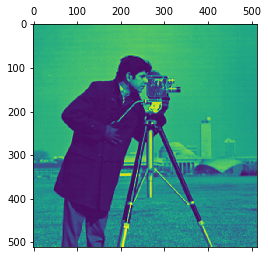

In [2]:
camera = data.camera()
plt.matshow(camera)

In [5]:
image1 = camera[50:200]
image2 = camera[150:300]
image3 = camera[250:400]

In [6]:
image1 = np.pad(image1, ((0,0),(0,38)), 'constant', constant_values=(0))
image2 = np.pad(image2, ((0,0),(38,0)), 'constant', constant_values=(0))
image3 = np.pad(image3, ((0,0),(19,19)), 'constant', constant_values=(0))

#### Now making a two-color camera

In [3]:
camera_invert = skimage.util.invert(camera)

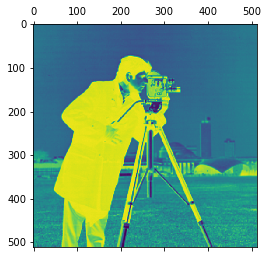

In [4]:
plt.matshow(camera_invert)

#### Combining into a two channel image

In [20]:
image1_invert = camera_invert[50:200]
image2_invert = camera_invert[150:300]
image3_invert = camera_invert[250:400]

In [21]:
image1 = camera[50:200]
image2 = camera[150:300]
image3 = camera[250:400]

In [27]:
camera_2chan_image1 = np.vstack((image1, image1_invert))
camera_2chan_image2 = np.vstack((image2, image2_invert))
camera_2chan_image3 = np.vstack((image3, image3_invert))

In [28]:
camera_2chan_image1 = np.pad(camera_2chan_image1, ((0,0),(0,38)), 'constant', constant_values=(0))
camera_2chan_image2 = np.pad(camera_2chan_image2, ((0,0),(38,0)), 'constant', constant_values=(0))
camera_2chan_image3 = np.pad(camera_2chan_image3, ((0,0),(19,19)), 'constant', constant_values=(0))

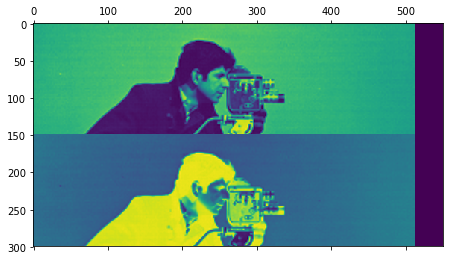

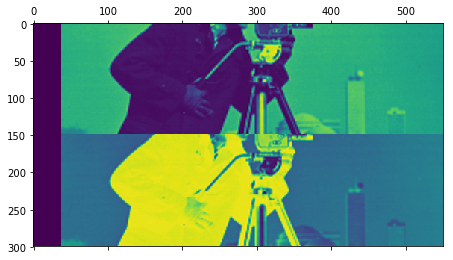

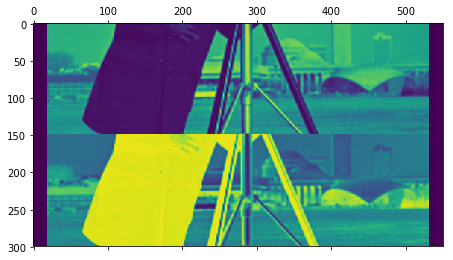

In [29]:
plt.matshow(camera_2chan_image1)
plt.matshow(camera_2chan_image2)
plt.matshow(camera_2chan_image3)

### Playing with apply_shift

In [11]:
translation = skimage.feature.register_translation(image2, image1)
translation = translation[0]
translation

array([ 50.,  38.])

In [64]:
shift = test_apply_shift(image2, image1, translation, margin=30)

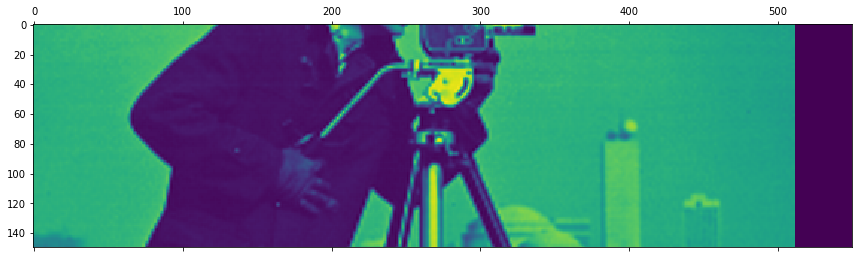

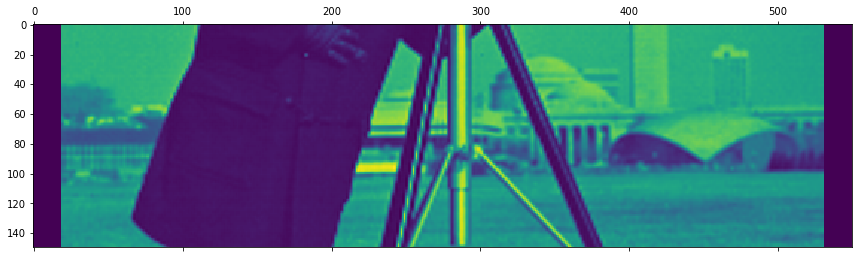

In [71]:
plt.matshow(shift[100:250],)
plt.matshow(image3)

In [68]:
image3.shape

(150, 550)

In [73]:
translation = skimage.feature.register_translation(image3, shift[100:250,])
translation = translation[0]
translation

array([ 51.,  19.])

In [74]:
all_three = test_apply_shift(image3, shift, translation, margin=30)

(349, 550)

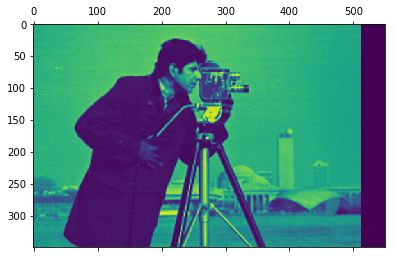

In [76]:
plt.matshow(all_three)
all_three.shape

In [57]:
def test_apply_shift(image1, image2, shift, margin=30):
    """ 
    Apply a lateral shift between two images, stitching them together
    
    Parameters
    ----------
    image1, image2 : 2D arrays
        The images to be stitched, *in order* (bottom, top)
    
    shift : sequence of length 2 
        x, y lateral shifts
    
    Returns
    -------
    Stitched image
    
    """
    cols1 = image1.shape[1]
    cols2 = image2.shape[1]
    rows1 = image1.shape[0]
    rows2 = image2.shape[0]

    overlap = int(abs(shift[0]))
    registered = np.zeros((rows1 + rows2 - overlap, cols1), dtype=int)
    registered[:rows2-margin] = image2[:rows2-margin]
    if shift[1] >= 0:
        registered[rows2-margin:, :cols1-int(shift[1])] = image1[overlap-margin:, int(shift[1]):] 
    else:
        registered[rows2-margin:, abs(int(shift[1])):] = image1[overlap-margin:, :int(shift[1])] 
    
    if margin > 0:
        fade2 = image2[rows2 - margin:rows2] * np.arange(1, 0, -(1/margin))[:, np.newaxis]
        fade1 = np.zeros_like(fade2)
        if shift[1] >= 0:
            fade1[:, :cols1-int(shift[1])] = (image1[overlap-margin:overlap, int(shift[1]):] * 
                                              np.arange(0, 1, (1/margin))[:, np.newaxis])
        else:
            fade1[:, abs(int(shift[1])):] = image1[overlap-margin:overlap, :int(shift[1])] * np.arange(0, 1, (1/margin))[:, np.newaxis]

        registered[rows2 - margin:rows2] = fade1 + fade2

    return registered.astype(int)

#### The problem was with overlap, switched to abs(shift[0])

### Now we have to fix find_shift

In [5]:
shift = ast2.find_shift(image2, image1)
shift

array([ 50.,  38.])

In [36]:
translation = skimage.feature.register_translation(image2[0:150,:], image1[0:150,:])
translation

(array([ 50.,  38.]), 0.49365498026746202, 6.1805587162139333e-16)

#### Problem is that a subsample of the image leads to poor registration in wide dimension

In [6]:
mosaic_12 = ast2.stitch(image2, image1, margin=30)
mosaic_12 = mosaic_12[0]

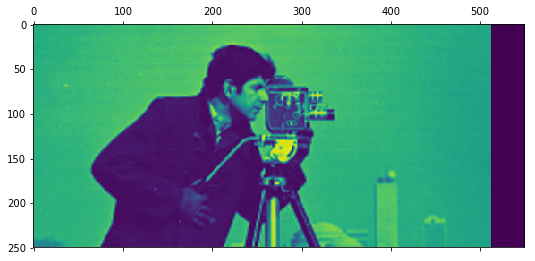

In [7]:
plt.matshow(mosaic_12)

In [9]:
mosaic_123 = ast2.stitch(image3, mosaic_12, margin=30)
mosaic_123 = mosaic_123[0]

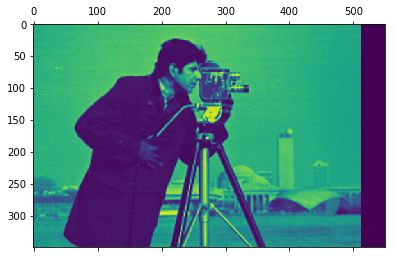

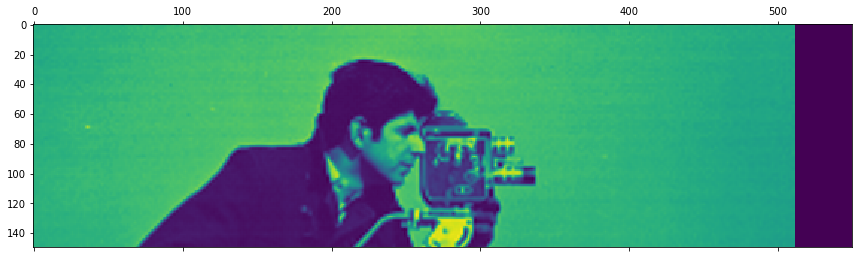

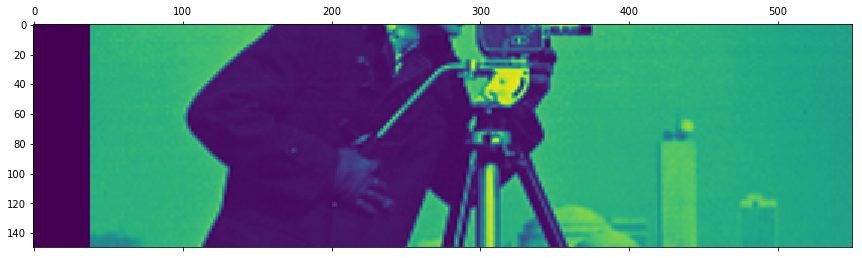

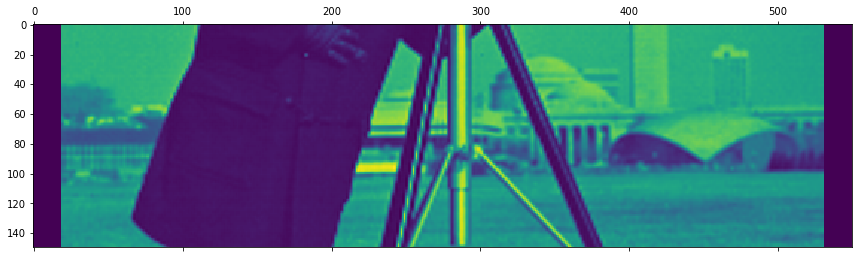

In [11]:
plt.matshow(mosaic_123)
plt.matshow(image1)
plt.matshow(image2)
plt.matshow(image3)

#### Great success! Stitching2 has effective find_shift, apply_shift, and stitch functions

### Creating z-stack, blurry images with depth

In [9]:
#creates 10 images in z-stack, crisp to blurry with increasing n
intervals = np.linspace(0.0,3.0,num=10)
for z in range(1,11):
    for number in intervals:
        image = (skimage.filters.gaussian(camera, number)*255).astype('uint8')
        strip1 = image[50:200]
        strip2 = image[150:300]
        strip3 = image[250:400]                    
        strip1 = np.pad(strip1, ((0,0),(0,38)), 'constant', constant_values=(0))
        strip2 = np.pad(strip2, ((0,0),(38,0)), 'constant', constant_values=(0))
        strip3 = np.pad(strip3, ((0,0),(19,19)), 'constant', constant_values=(0))
        z = int(number*3+1) 
        tiff.imsave("camera_strip1_z%01d.tif" % z , strip1)
        tiff.imsave("camera_strip2_z%01d.tif" % z , strip2)
        tiff.imsave("camera_strip3_z%01d.tif" % z , strip3)

In [10]:
images1= imread_collection("../notebooks/camera_strip1_z*")
images2= imread_collection("../notebooks/camera_strip2_z*")
images3= imread_collection("../notebooks/camera_strip3_z*")

In [11]:
mosaic_12 = ast2.stitch_zstack(images2, images1, nchan=1, chan=0, margin=30, current_stack=None, out_path=None)

ValueError: could not broadcast input array from shape (50,512) into shape (200,512)

In [12]:
debug

> /home/nicholasreder/alpenglow/alpenglow/stitching2.py(79)apply_shift()
     77     registered[:rows2-margin] = image2[:rows2-margin]
     78     if shift[1] >= 0:
---> 79         registered[rows2-margin:, :cols1-int(shift[1])] = image1[overlap-margin:, int(shift[1]):]
     80     else:
     81         registered[rows2-margin:, abs(int(shift[1])):] = image1[overlap-margin:, :int(shift[1])]

ipdb> margin
100
ipdb> q


In [ ]:
mosaic_12 = ast2.output_zstack(images2, images1, 1, margin=30)


### 2 channel case

#### First create z-stack that blurs with depth

### Memmap case